In [1]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Carico il file e stampo a schermo per fare una prova

In [3]:
train = pd.read_csv('train.csv')
train.head()

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,939,15668032,Buchanan,577,France,Female,37,4,0.00,1,1,1,79881.39
1,0,7656,15594651,Milani,748,France,Male,38,4,115221.36,1,0,1,70956.75
2,0,8378,15567147,Ratten,802,Spain,Male,40,4,0.00,2,1,1,81908.09
3,0,3395,15668460,Bellucci,466,France,Male,29,6,0.00,2,1,1,2797.27
4,0,9979,15703563,P'eng,774,France,Male,40,9,93017.47,2,1,0,191608.97


### E' sempre buona norma dare un'occhiata agli attributi per sapere di cosa si sta parlando:

In [4]:
train.dtypes

Exited               int64
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

##### Controllo la presenza di eventuali valori null

In [5]:
train.isnull().sum()

Exited             0
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

## Idea di base:
### A primo impatto, un modello che potrei ritenere opportuno per affrontare il problema è quello di un decision tree, voglio però studiare gli attributi per vedere se alcuni hanno più rilevanza di altri, ed eventualmente rimuovere quelli che non aiutano in alcun modo all' addestramento.

### Si va ora a studiare quanto questi attributi siano correlati con l'abbandono del cliente dalla compagnia

Fra gli atributi, si nota che il cognome abbia una bassa probabilità di essere la causa dell'abbandono del cliente. Se si dovesse verificare una qualche correlazione si tratterebbe più di un problema personale piuttosto che aziendale. Bisogna ricordarsi dunque di effettuare un drop dell'attributi 'Surname', così come di RowNumber e CustomerId in quanto si tratta di notazioni identificative per le aaplicazioni, non vi è anche in questo caso nessuna relazione aziendale utile.

### Iniziamo a confrontare il numero di abbandoni in base agli attributi "classificatori" relativi al cliente.

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

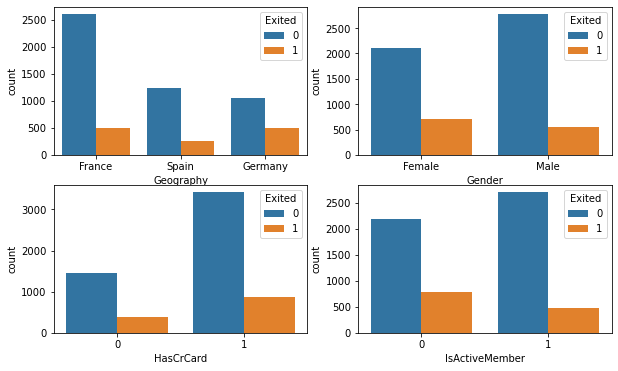

In [6]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 6))
sns.countplot(x='Geography', hue = 'Exited',data = train, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = train, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = train, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = train, ax=axarr[1][1])


Si nota come i clienti che non hanno ancora abbandonato sono principalmente provenienti dalla francia e per qunato riguarda il genere si ha una maggiornaza di utenza mantenuta maschile piuttosto che femminile. Inaspettatamente, la maggior parte dei clienti che abbandona l'azienda lo fa pur avendo una carta e, senza sorprenderci troppo vediamo come la maggior parte degli abbadoni è da parte di clienti che non sono attivi.

#### Passiamo ora ad uno studio degli attributi numerali

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

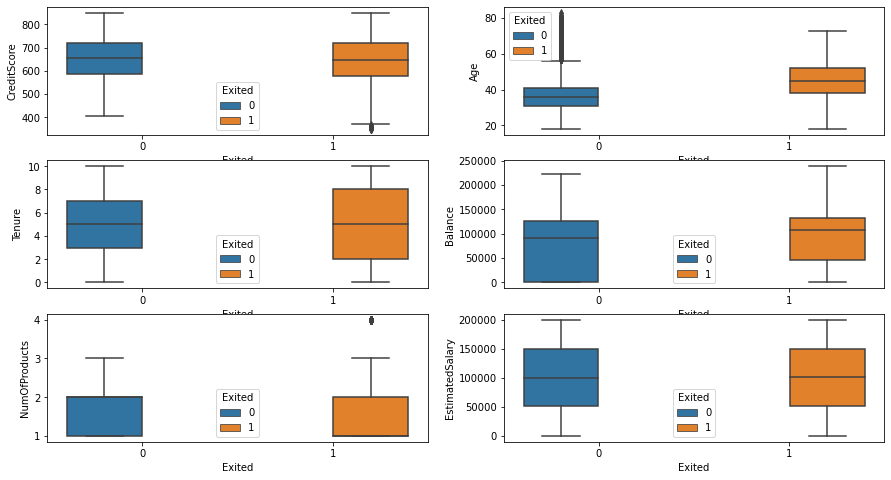

In [7]:
fig, axarr = plt.subplots(3, 2, figsize=(15, 8))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = train, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = train , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = train, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = train, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = train, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = train, ax=axarr[2][1])

##### I risultati che saltano di più all'occhio riguardano gli attributi Age e NumOfProduct:

La densità dell'attributo 'Age' rispetto agli abbandoni presenta un picco su 2 principali fasce d'età: vi è un'abbandono circa del 60% nella fascia che va dai 50 ai 60 e un (non sorpredente) 80% nella fascia che va dagli 80 ai 90. La prima fascia potrebbe essere data per via di manovre commerciali che hanno un target più giovanile.

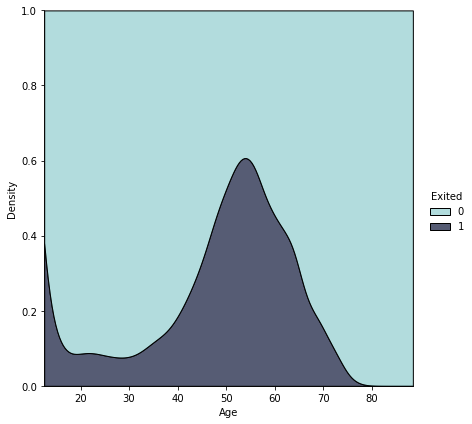

In [8]:
sns.displot(
    data=train,
    x="Age", hue="Exited",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

Quella relativa a 'NumOfProduct' si comporta in modo simile: per clienti che utilizzano un solo prodotto aziendale si ha un'abbandono del 20% circa, valore che si abbassa per clienti che utilizzano 2 prodotti(circa 5 percento), per poi impennarsi al crescere del valore dell'attributo considerato.

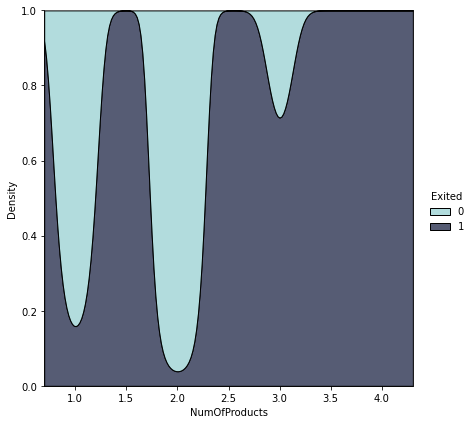

In [9]:
sns.displot(
    data=train,
    x="NumOfProducts", hue="Exited",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)

### Lo studio degli attributi ha mostrato molti chiari scuri riferendosi agli abbandoni dei clienti, ma si è riscontrato un contributo quanto meno distribuito di ogni feature nella determinazione di una previsione dell'abbandono di un certo cliente.

## Una volta definito, si passa alla costrusione e addestramento del modello

In [10]:
test = pd.read_csv('test.csv')
test.head()

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,3189,15586757,Anenechukwu,801,France,Female,32,4,75170.54,1,1,1,37898.50
1,0,8294,15770711,Lu,766,Germany,Female,28,4,90696.78,1,0,1,21597.20
2,0,1711,15567993,Palmer,828,Spain,Male,28,8,134766.85,1,1,0,79355.87
3,0,7511,15729377,Ku,798,France,Male,36,1,0.00,2,1,1,159044.10
4,0,1462,15640627,Wan,611,Spain,Male,34,4,0.00,2,1,0,170950.58


#### Ricordiamo come alcuni attributi fossero di tipo object, dunque concluso lo studio vanno "tradotti" in numeri

In [11]:
from sklearn.preprocessing import LabelEncoder

for label in train.columns:
    if(label in ['Geography', 'Gender']):
        train[label] = LabelEncoder().fit_transform(train[label])
train.head()

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,939,15668032,Buchanan,577,0,0,37,4,0.00,1,1,1,79881.39
1,0,7656,15594651,Milani,748,0,1,38,4,115221.36,1,0,1,70956.75
2,0,8378,15567147,Ratten,802,2,1,40,4,0.00,2,1,1,81908.09
3,0,3395,15668460,Bellucci,466,0,1,29,6,0.00,2,1,1,2797.27
4,0,9979,15703563,P'eng,774,0,1,40,9,93017.47,2,1,0,191608.97


In [12]:
from sklearn.preprocessing import LabelEncoder

for label in test.columns:
    if(label in ['Geography', 'Gender']):
        test[label] = LabelEncoder().fit_transform(test[label])
test.head()

,Exited,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0,3189,15586757,Anenechukwu,801,0,0,32,4,75170.54,1,1,1,37898.50
1,0,8294,15770711,Lu,766,1,0,28,4,90696.78,1,0,1,21597.20
2,0,1711,15567993,Palmer,828,2,1,28,8,134766.85,1,1,0,79355.87
3,0,7511,15729377,Ku,798,0,1,36,1,0.00,2,1,1,159044.10
4,0,1462,15640627,Wan,611,2,1,34,4,0.00,2,1,0,170950.58


#### Ricordiamoci inoltre della decisione che abbiamo preso precedentemente, di eseguire un drop degli attributi 'Surname', 'RowNumber' e 'CustomerId'

In [13]:
train = train.drop(columns=['Surname'])
train = train.drop(columns=['RowNumber'])
train = train.drop(columns=['CustomerId'])

In [14]:
test = test.drop(columns=['Surname'])
test = test.drop(columns=['RowNumber'])
test = test.drop(columns=['CustomerId'])

### Si procedo allora alla costruzione di un modello di decision tree per la classificazione

In [15]:
y_train = train["Exited"].values
x_train = train.drop(["Exited"], axis=1).values
y_test = test["Exited"].values
x_test = test.drop(["Exited"], axis=1).values

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(dt.score(x_train, y_train)))
print("Accuracy on test set: {:.5f}".format(dt.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.79402


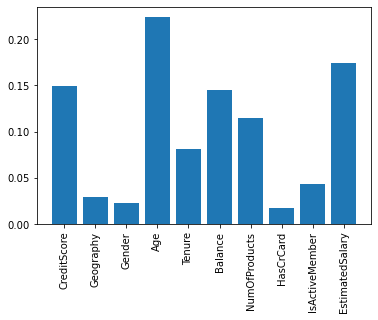

In [17]:
plt.bar(test.columns.drop(["Exited"]), dt.feature_importances_)
plt.xticks(test.columns.drop(["Exited"]), test.columns.drop(["Exited"]), rotation='vertical')
plt.show()

#### A fronte dei risutlati di addeestramento notiamo che, per quanto non sia un contrasto estremo, gli attributi 'Geography', 'Gender' e 'HasCrCard' forniscono un apporto informativo minore, andimao ad addetrare il modello senza questi tre attributi per vedere quanto sia marcato loro contributo a fronte del risutato totale.

In [18]:
train = train.drop(columns=['Geography'])
train = train.drop(columns=['Gender'])
train = train.drop(columns=['HasCrCard'])

In [19]:
test = test.drop(columns=['Geography'])
test = test.drop(columns=['Gender'])
test = test.drop(columns=['HasCrCard'])

In [20]:
y_train = train["Exited"].values
x_train = train.drop(["Exited"], axis=1).values
y_test = test["Exited"].values
x_test = test.drop(["Exited"], axis=1).values

In [21]:
dt2 = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt2.fit(x_train, y_train)
print("Accuracy on training set: {:.3f}".format(dt2.score(x_train, y_train)))
print("Accuracy on test set: {:.5f}".format(dt2.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.79402


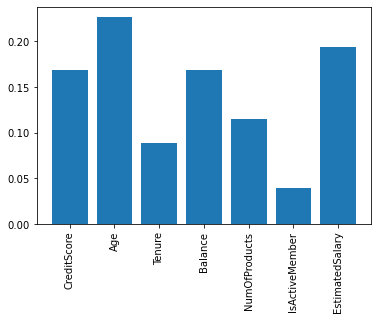

In [22]:
plt.bar(test.columns.drop(["Exited"]), dt2.feature_importances_)
plt.xticks(test.columns.drop(["Exited"]), test.columns.drop(["Exited"]), rotation='vertical')
plt.show()

## CONCLUSIONI:
Questo ltimo studio mostra che effettivamente esiste una sfumatura nell'importanza che ha ogni attributo nella previsione. Possiamo dunque effettuare previsioni con un'accuratezza del 79% e, nel farlo, possiamo non considerare gli attributi legati al sesso, allo stato di appartenenza e al fatto che il cliente abbia o meno una carta di ceùredito.
Sono sorpreso dai risultati dell'addestramento in quanto non mi aspettavo un apporto informativo così basso da parte di questi attributi in fase di analisi, non escludo la possibilità di aver commesso delgi errori in una fase o nell'altra.